In [1]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings

In [2]:
adata = sc.read_h5ad("/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/snPATHO-seq/adata_lab_lv2-B-1970164-01-04_2,epi.h5ad")

In [6]:
adata.layers['raw'] = adata.X.copy()

In [7]:
adata

AnnData object with n_obs × n_vars = 15497 × 15502
    obs: 'library', 'barcode', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid_lv1', 'lab_lv1', 'kid_lv2', 'lab_lv2'
    var: 'gene_id', 'gene_symbol', 'hv'
    uns: 'X_name'
    obsm: 'PCA', 'UMAP'
    layers: 'logcounts', 'raw'

#### Add genomic positions

In [11]:
import pandas as pd

def add_genomic_positions(adata):
    ''' Adds gene positions to the AnnData object. The adata.var_names have to be EnsmblIDs. The data is taken from the Ensmbl BioMart human dataset GRCh38.p14. 

    param:
        adata (AnnData object): the annotated dataset where the gene postions should be added
    output: 
        adata (AnnData object): the annotated dataset where the genes are added
 
    '''

    
    # Load the gene positions data
    gene_file = ("/home/augusta/SSS_mount/insituCNV/InSituCNV/Ensmbl_BioMart_gene_info.txt")
    gene_positions_df = pd.read_csv(gene_file)

    # Create a dictionary for quick lookup
    gene_dict = gene_positions_df.set_index("Gene stable ID")[["Chromosome/scaffold name", "Gene start (bp)", "Gene end (bp)"]].to_dict("index")

    # Format chromosome names
    format_chromosome = lambda x: f"chr{x}"

    # Initialize counters
    genes_identified = 0

    # Iterate over the genes in adata
    for gene_id in adata.var_names:
        if gene_id in gene_dict:
            info = gene_dict[gene_id]
            adata.var.loc[gene_id, ["chromosome", "start", "end"]] = [format_chromosome(info["Chromosome/scaffold name"]), info["Gene start (bp)"], info["Gene end (bp)"]]
            genes_identified += 1

    # Print summary of identified genes
    print(f"{genes_identified} gene positions identified \n{adata.shape[1] - genes_identified} were not found")
    return adata

In [12]:
adata.var_names = adata.var.gene_id

In [13]:
add_genomic_positions(adata)

14928 gene positions identified 
574 were not found


AnnData object with n_obs × n_vars = 15497 × 15502
    obs: 'library', 'barcode', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid_lv1', 'lab_lv1', 'kid_lv2', 'lab_lv2'
    var: 'gene_id', 'gene_symbol', 'hv', 'chromosome', 'start', 'end'
    uns: 'X_name'
    obsm: 'PCA', 'UMAP'
    layers: 'logcounts', 'raw'

#### Preprocessing

In [48]:
adata.layers['logtransformed'] = adata.layers['raw'].copy()

In [50]:
sc.pp.normalize_total(adata, layer = 'logtransformed')

In [51]:
sc.pp.log1p(adata, layer = 'logtransformed')

In [52]:
print(adata.layers['raw'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 58660690 stored elements and shape (39075, 15502)>
  Coords	Values
  (0, 1)	1.0
  (0, 7)	3.0
  (0, 13)	7.0
  (0, 19)	1.0
  (0, 20)	2.0
  (0, 21)	1.0
  (0, 23)	3.0
  (0, 25)	2.0
  (0, 26)	8.0
  (0, 33)	3.0
  (0, 37)	2.0
  (0, 39)	2.0
  (0, 40)	2.0
  (0, 46)	1.0
  (0, 47)	1.0
  (0, 48)	4.0
  (0, 51)	1.0
  (0, 53)	1.0
  (0, 57)	1.0
  (0, 59)	2.0
  (0, 66)	1.0
  (0, 73)	1.0
  (0, 75)	1.0
  (0, 78)	1.0
  (0, 83)	1.0
  :	:
  (39074, 14609)	1.0
  (39074, 14643)	1.0
  (39074, 14650)	1.0
  (39074, 14663)	1.0
  (39074, 14689)	1.0
  (39074, 14705)	1.0
  (39074, 14715)	1.0
  (39074, 14724)	1.0
  (39074, 14738)	1.0
  (39074, 14777)	1.0
  (39074, 14787)	1.0
  (39074, 14799)	1.0
  (39074, 14831)	2.0
  (39074, 14835)	1.0
  (39074, 14846)	1.0
  (39074, 14873)	1.0
  (39074, 14920)	1.0
  (39074, 14936)	1.0
  (39074, 14977)	3.0
  (39074, 15000)	1.0
  (39074, 15026)	2.0
  (39074, 15046)	1.0
  (39074, 15081)	2.0
  (39074, 15485)	1.0
  (39074, 154

In [54]:
print(adata.layers['logtransformed'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 58660690 stored elements and shape (39075, 15502)>
  Coords	Values
  (0, 1)	0.13890076553140607
  (0, 7)	0.3695133312087414
  (0, 13)	0.7144538285017645
  (0, 19)	0.13890076553140607
  (0, 20)	0.26084013887330804
  (0, 21)	0.13890076553140607
  (0, 23)	0.3695133312087414
  (0, 25)	0.26084013887330804
  (0, 26)	0.7848511309720637
  (0, 33)	0.3695133312087414
  (0, 37)	0.26084013887330804
  (0, 39)	0.26084013887330804
  (0, 40)	0.26084013887330804
  (0, 46)	0.13890076553140607
  (0, 47)	0.13890076553140607
  (0, 48)	0.46752574417761156
  (0, 51)	0.13890076553140607
  (0, 53)	0.13890076553140607
  (0, 57)	0.13890076553140607
  (0, 59)	0.26084013887330804
  (0, 66)	0.13890076553140607
  (0, 73)	0.13890076553140607
  (0, 75)	0.13890076553140607
  (0, 78)	0.13890076553140607
  (0, 83)	0.13890076553140607
  :	:
  (39074, 14609)	1.253874079720791
  (39074, 14643)	1.253874079720791
  (39074, 14650)	1.253874079720791
  (39074, 14663)	

#### Infer CNV

In [9]:
adata.obs.lab_lv2.unique()

['epi. stem', 'MT-high', 'epi. goblet', 'epi. paneth', 'epi. progen.', 'epi. fetal', 'epi. absorp.', 'epi. entero.']
Categories (8, object): ['MT-high', 'epi. absorp.', 'epi. entero.', 'epi. fetal', 'epi. goblet', 'epi. paneth', 'epi. progen.', 'epi. stem']

In [27]:
# We provide all immune cell types as "normal cells".
cnv.tl.infercnv(
    adata,
    layer = 'raw',
    window_size=100,
    reference_key = 'lab_lv2',
    reference_cat = ['epi. entero.']
)

# We provide "normal" cells as reference

  0%|          | 0/4 [00:00<?, ?it/s]

#### Cluster cells based on their CNV profile

In [28]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)

In [ ]:
cnv.tl.leiden(adata,resolution=0.2)

In [31]:
# cnv.tl.cnv_score(adata)

#### Plot CNV heatmaps

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


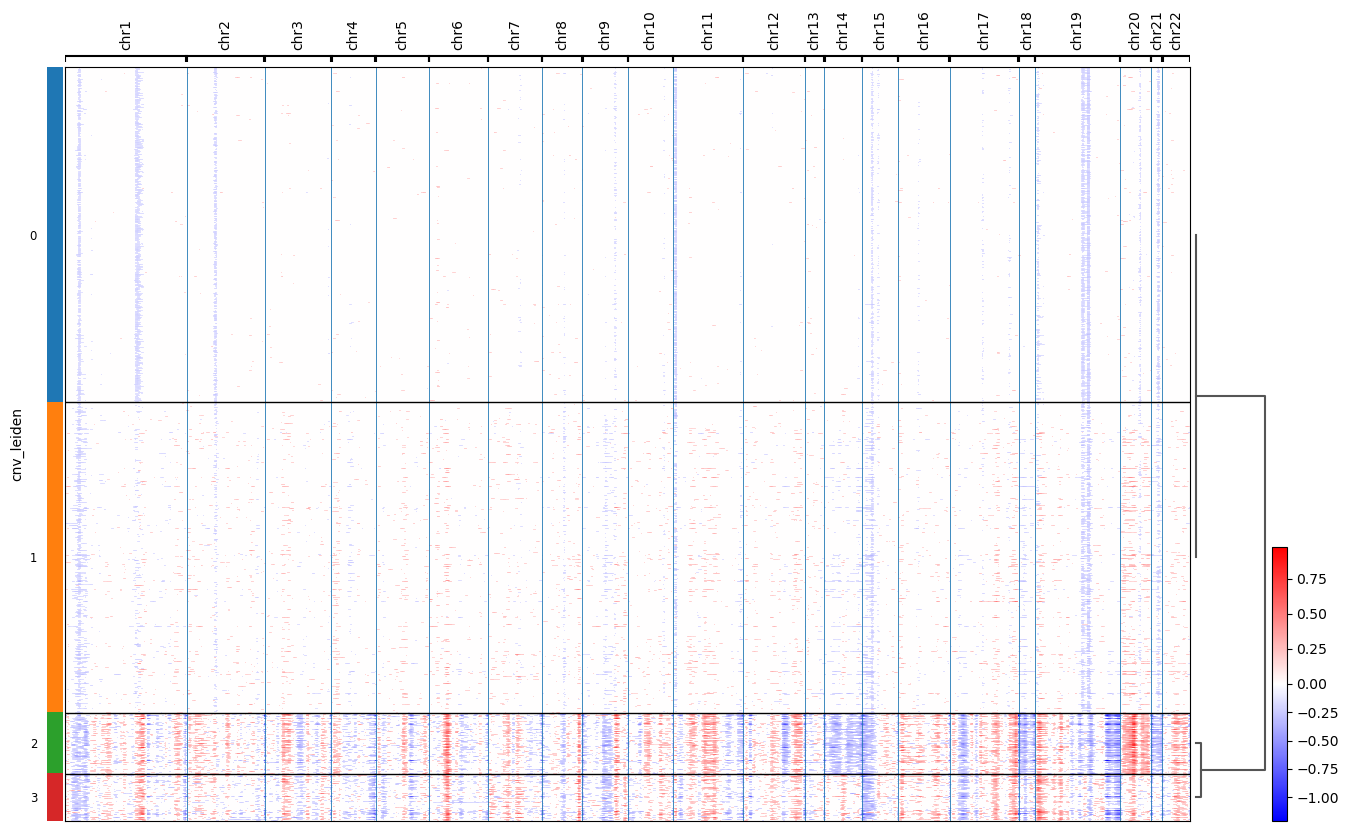

In [30]:
# raw
sc.tl.dendrogram(adata, groupby='cnv_leiden')
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

categories: MT-high, epi. absorp., epi. entero., etc.
var_group_labels: chr1, chr2, chr3, etc.


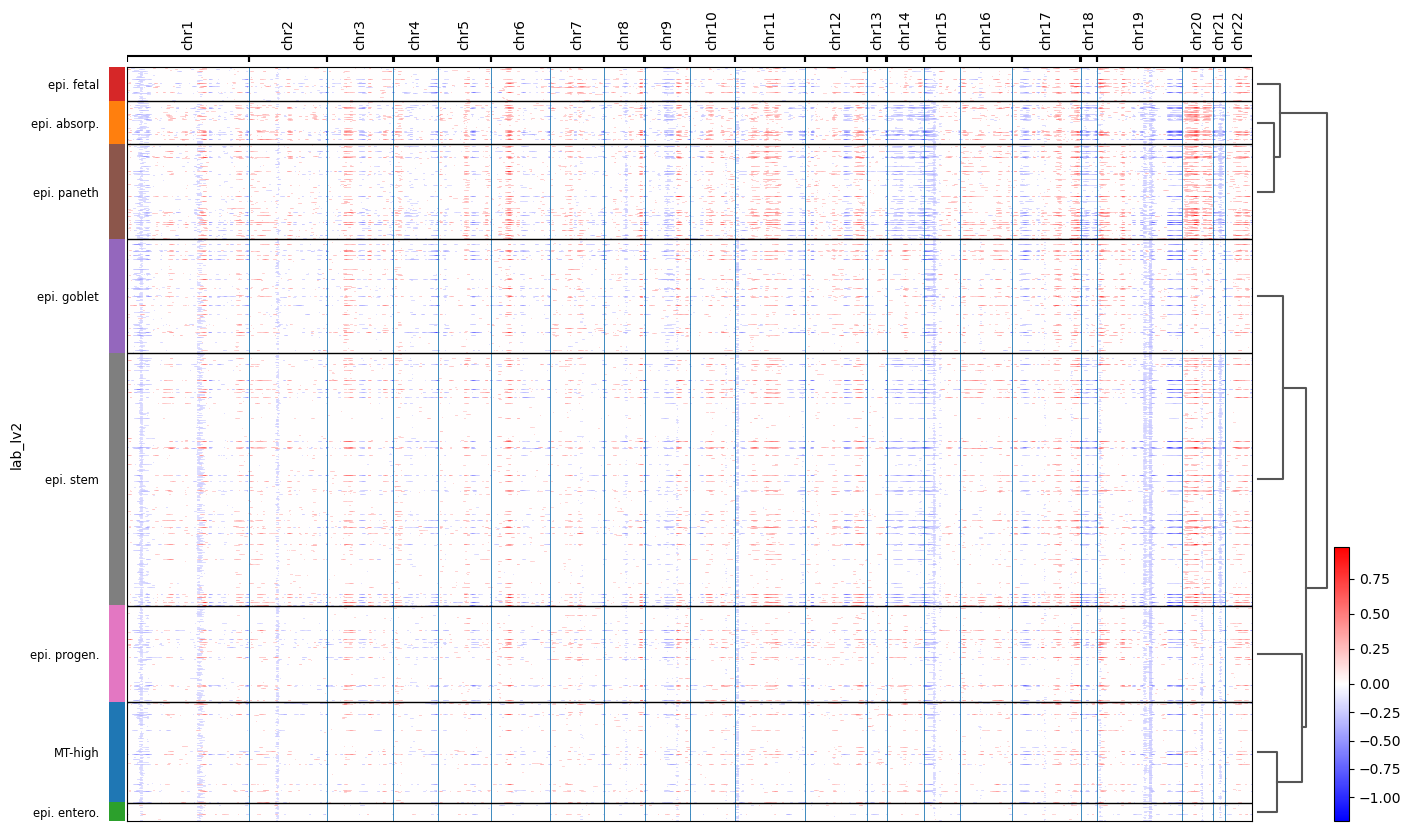

In [32]:
# raw
sc.tl.dendrogram(adata, groupby='lab_lv2')
cnv.pl.chromosome_heatmap(adata, groupby="lab_lv2", dendrogram=True)

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1
var_group_labels: chr1, chr2, chr3, etc.


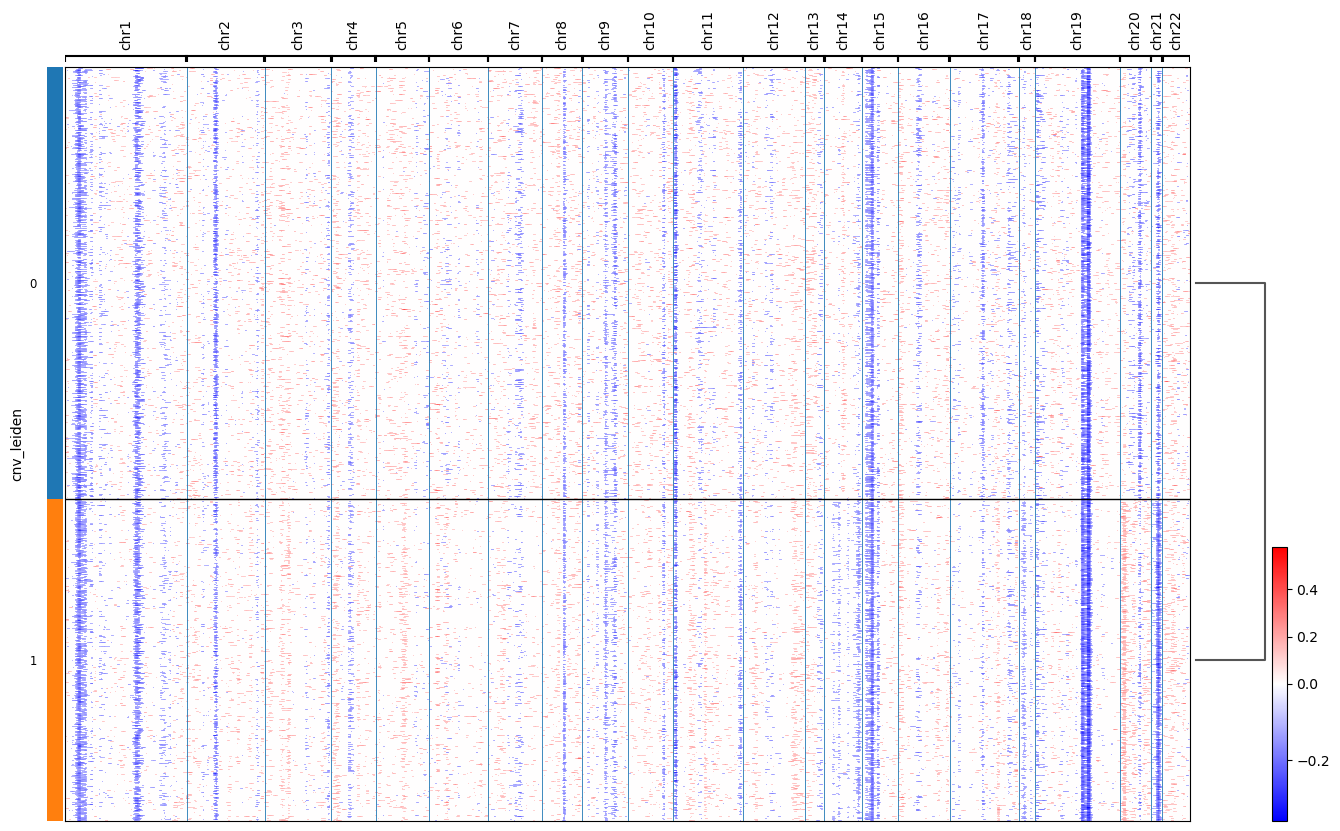

In [25]:
# logcounts
sc.tl.dendrogram(adata, groupby='cnv_leiden')
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

In [ ]:
# logcounts
cnv.pl.chromosome_heatmap(adata, groupby="leiden", dendrogram=True)

In [ ]:
# logtranformed
cnv.pl.chromosome_heatmap(adata, groupby="leiden", dendrogram=True)

In [ ]:
# raw
cnv.pl.chromosome_heatmap(adata, groupby="dataset", dendrogram=True, vmax = 0.4, vmin=-0.4)

In [ ]:
# logcounts
cnv.pl.chromosome_heatmap(adata, groupby="dataset", dendrogram=True, vmax = 0.4, vmin=-0.4)

In [ ]:
# logtransformed
cnv.pl.chromosome_heatmap(adata, groupby="dataset", dendrogram=True)

In [32]:
sc.tl.dendrogram(adata, groupby ='cnv_leiden')

In [ ]:
# raw
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=False)

In [ ]:
# logcounts
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=False)

In [ ]:
# logtransformed
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=False)